In [1]:
# -*- coding: utf-8 -*-

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import time
from methods.gromov_funcs import define_loss_function, gw_distance, spar_gw, sampled_gw, entropic_gw
from data_simulators import data_generator
import methods.GromovWassersteinGraphToolkit as GwGt
import methods.GromovWassersteinFramework as GWF

np.random.seed(123)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#############################################################################
#
# Define the loss function
# ---------------------------------------------

loss_func_name = 'square_loss'
loss_func = define_loss_function(loss_func_name)


if loss_func_name == 'square_loss':
    gromov_loss_func = loss_func_name
else:
    gromov_loss_func = loss_func

In [3]:
#############################################################################
#
# Setup
# ---------------------------------------------

n1_list = np.array([25, 50, 100, 200, 500])
n2_list = np.array([25, 50, 100, 200, 500])
eps_list = np.array([1, 1e-1, 1e-2, 1e-3])
nloop = 5

dist_emd = np.zeros(len(n1_list))
dist_egw = np.zeros([len(n1_list), len(eps_list)])
dist_pga = np.zeros([len(n1_list), len(eps_list)])
dist_sgwl = np.zeros([len(n1_list), len(eps_list)])
dist_lrgw = np.zeros([len(n2_list), len(eps_list)])
dist_sagrow = np.zeros([nloop, len(n2_list), len(eps_list)])
dist_spargw = np.zeros([nloop, len(n2_list), len(eps_list)])

time_emd = np.zeros(len(n1_list))
time_egw = np.zeros([len(n1_list), len(eps_list)])
time_pga = np.zeros([len(n1_list), len(eps_list)])
time_sgwl = np.zeros([len(n1_list), len(eps_list)])
time_lrgw = np.zeros([len(n2_list), len(eps_list)])
time_sagrow = np.zeros([nloop, len(n2_list), len(eps_list)])
time_spargw = np.zeros([nloop, len(n2_list), len(eps_list)])

In [4]:
#############################################################################
#
# Compute the GW distance
# ---------------------------------------------

j = 0
for j in range(len(n2_list)):
    n = n2_list[j]
    print('n =', n)
    
    np.random.seed(123+321*j)
    a, b, C1, C2, cost_s, cost_t = data_generator('graph', n)


    ################ EMD-GW ################
    stime = time.process_time()
    trans_emd = entropic_gw(C1, C2, a, b, gromov_loss_func, epsilon=0)
    time_emd[j] = time.process_time()-stime 
    dist_emd[j] = gw_distance(C1, C2, gromov_loss_func, trans_emd)
    
    
    for k in range(len(eps_list)):
        epsilon = eps_list[k]
        
        ################ Spar-GW ################
        for i in range(nloop):
            stime = time.process_time()
            trans_spargw = spar_gw(cost_s, cost_t, a, b, gromov_loss_func, 2**4*n, epsilon, con_loop=int(n/20),
                                   random_state=123+100*j+421*i+22*k)
            time_spargw[i,j,k] = time.process_time()-stime
            if np.sum(trans_spargw) < 0.9:
                dist_spargw[i,j,k] = np.nan
            else:
                dist_spargw[i,j,k] = gw_distance(C1, C2, gromov_loss_func, trans_spargw)

        
        ################ SaGroW ################
        for i in range(nloop):
            stime = time.process_time()
            trans_sagrow = sampled_gw(C1, C2, a, b, loss_func, 2**4*n, epsilon, con_loop=20,
                                      KL=True, random_state=123+100*j+421*i+22*k)
            time_sagrow[i,j,k] = time.process_time()-stime
            if np.sum(trans_sagrow) < 0.9:
                dist_sagrow[i,j,k] = np.nan
            else:
                dist_sagrow[i,j,k] = gw_distance(C1, C2, gromov_loss_func, trans_sagrow)



        ot_dict = {'loss_type': gromov_loss_func, 
                    'ot_method': 'proximal',
                    'beta': epsilon,
                    'outer_iteration': 100,
                    # outer, inner iteration, error bound of optimal transport
                    'iter_bound': 1e-9,
                    'inner_iteration': 10,
                    'sk_bound': 1e-9,
                    'node_prior': 1e3,
                    'max_iter': 4,  # iteration and error bound for calcuating barycenter
                    'cost_bound': 1e-26,
                    'update_p': False,  # optional updates of source distribution
                    'lr': 0,
                    'alpha': 0,
                    'rank': int(n/10),
                    'reg': epsilon,
                    'lower-bound': 1e-10}
    
        
        ################ LR-GW ################
        stime = time.process_time()
        trans_lrgw = GWF.Lin_LOT_MD(cost_s=cost_s,
                                    cost_t=cost_t,
                                    a=a[:,None],
                                    b=b[:,None],
                                    rank=ot_dict['rank'],
                                    reg=ot_dict['reg'],
                                    alpha=ot_dict['lower-bound'],
                                    max_iter=ot_dict['outer_iteration'])
        trans_lrgw /= np.sum(trans_lrgw)
        time_lrgw[j,k] = time.process_time()-stime
        dist_lrgw[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_lrgw)
        
        if n <= n1_list[-1]:
    
            ################ S-GWL ################
            stime = time.process_time()
                
            idx2node_s = {}
            idx2node_t = {}
            for ii in range(n):
                idx2node_s[ii] = ii
            for ii in range(n):
                idx2node_t[ii] = ii
        
            pairs_idx, pairs_name, pairs_confidence = GwGt.recursive_direct_graph_matching(
                cost_s=cost_s, cost_t=cost_s,
                p_s=a[:,None], p_t=b[:,None],
                idx2node_s=idx2node_s, idx2node_t=idx2node_t, ot_hyperpara=ot_dict,
                weights=None, predefine_barycenter=False, cluster_num=2,
                partition_level=3, max_node_num=0)
        
            pairs_idx = np.array(pairs_idx)
            trans_sgwl = np.zeros((C1.shape[0], C2.shape[0]))
            trans_sgwl[pairs_idx[:, 0], pairs_idx[:, 1]] = a[pairs_idx[:, 0]]
            trans_sgwl /= np.sum(trans_sgwl)

            time_sgwl[j,k] = time.process_time()-stime
            dist_sgwl[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_sgwl)
        
            
            ################ EGW ################
            stime = time.process_time()
            trans_egw = entropic_gw(C1, C2, a, b, gromov_loss_func, epsilon)
            time_egw[j,k] = time.process_time()-stime
            dist_egw[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_egw)
            
            
            ################ PGA-GW ################
            stime = time.process_time()
            trans_pga = entropic_gw(C1, C2, a, b, gromov_loss_func, epsilon, KL=True)
            time_pga[j,k] = time.process_time()-stime
            dist_pga[j,k] = gw_distance(C1, C2, gromov_loss_func, trans_pga)

n = 25
n = 50
n = 100
n = 200
Warning catched in Sinkhorn
n = 500
Warning catched in Sinkhorn
Warning catched in Sinkhorn
Warning catched in Sinkhorn


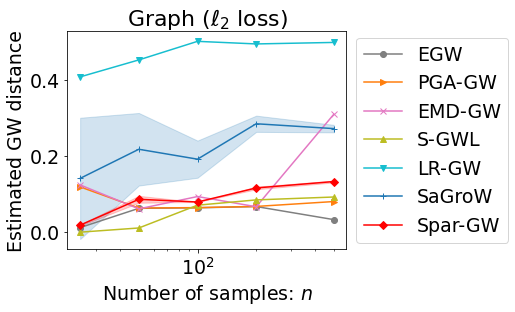

In [5]:
#############################################################################
#
# Plot the estimated GW distance
# ---------------------------------------------

mean_dist_sagrow = np.nanmean(dist_sagrow, axis=0)
mean_dist_spargw = np.nanmean(dist_spargw, axis=0)

temp = tuple((np.array(range(len(n2_list))), np.nanargmin(mean_dist_sagrow, axis=1)))
std_dist_sagrow = np.nanstd(dist_sagrow, axis=0)[temp[0],temp[1]]
temp = tuple((np.array(range(len(n2_list))), np.nanargmin(mean_dist_spargw, axis=1)))
std_dist_spargw = np.nanstd(dist_spargw, axis=0)[temp[0],temp[1]]


plt.figure(2, figsize=(5, 4))
pl.clf()
plt.title(r'Graph ($\ell_2$ loss)', fontsize=22)
plt.plot(n1_list, np.nanmin(dist_egw, axis=1), color='tab:grey', marker='o', linestyle='-', label='EGW')
plt.plot(n1_list, np.nanmin(dist_pga, axis=1), color='tab:orange', marker='>', linestyle='-', label='PGA-GW')
plt.plot(n1_list, dist_emd, color='tab:pink', marker='x', linestyle='-', label='EMD-GW')
plt.plot(n1_list, np.nanmin(dist_sgwl, axis=1), color='tab:olive', marker='^', linestyle='-', label='S-GWL')
plt.plot(n2_list, np.nanmin(dist_lrgw, axis=1), color='tab:cyan', marker='v', linestyle='-', label='LR-GW')
plt.plot(n2_list, np.nanmin(mean_dist_sagrow, axis=1), color='tab:blue', marker='+', linestyle='-', label='SaGroW')
plt.fill_between(n2_list, np.nanmin(mean_dist_sagrow, axis=1)-std_dist_sagrow, 
                 np.nanmin(mean_dist_sagrow, axis=1)+std_dist_sagrow, color='tab:blue', alpha=0.2)
plt.plot(n2_list, np.nanmin(mean_dist_spargw, axis=1), color='red', marker='D', linestyle='-', label='Spar-GW')
plt.fill_between(n2_list, np.nanmin(mean_dist_spargw, axis=1)-std_dist_spargw, 
                 np.nanmin(mean_dist_spargw, axis=1)+std_dist_spargw, color='red', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=19)
plt.xlabel(r'Number of samples: $n$', fontsize=19)
plt.ylabel('Estimated GW distance', fontsize=19)
plt.xscale('log') 
plt.tick_params(labelsize=19)
plt.show()

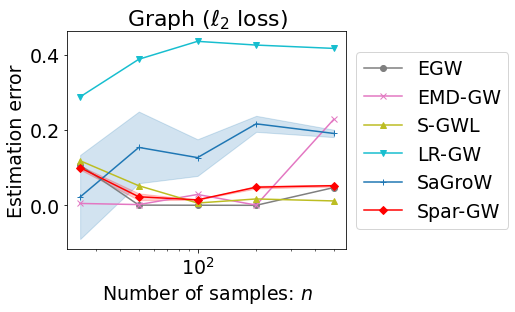

In [6]:
#############################################################################
#
# Plot the estimation error
# ---------------------------------------------

oracle = np.nanmin(dist_pga, axis=1)
err_egw = np.abs(np.nanmin(dist_egw, axis=1) - oracle)
err_emd = np.abs(dist_emd - oracle)
err_sgwl = np.abs(np.nanmin(dist_sgwl, axis=1) - oracle)
err_lrgw = np.abs(np.nanmin(dist_lrgw, axis=1) - oracle)
err_sagrow = np.abs(np.nanmin(mean_dist_sagrow, axis=1) - oracle)
err_spargw = np.abs(np.nanmin(mean_dist_spargw, axis=1) - oracle)

meta_oracle = np.tile(np.tile(oracle, (dist_sagrow.shape[2], 1)).T, (dist_sagrow.shape[0], 1, 1))
meta_err_sagrow = abs(dist_sagrow - meta_oracle)
meta_err_spargw = abs(dist_spargw - meta_oracle)

mean_err_sagrow = np.nanmean(meta_err_sagrow, axis=0)
mean_err_spargw = np.nanmean(meta_err_spargw, axis=0)

temp = tuple((np.array(range(len(n2_list))), np.nanargmin(mean_err_sagrow, axis=1)))
std_err_sagrow = np.nanstd(meta_err_sagrow, axis=0)[temp[0],temp[1]]
temp = tuple((np.array(range(len(n2_list))), np.nanargmin(mean_err_spargw, axis=1)))
std_err_spargw = np.nanstd(meta_err_spargw, axis=0)[temp[0],temp[1]]


plt.figure(3, figsize=(5, 4))
pl.clf()
plt.title(r'Graph ($\ell_2$ loss)', fontsize=22)
plt.plot(n1_list, err_egw, color='tab:grey', marker='o', linestyle='-', label='EGW')
plt.plot(n1_list, err_emd, color='tab:pink', marker='x', linestyle='-', label='EMD-GW')
plt.plot(n1_list, err_sgwl, color='tab:olive', marker='^', linestyle='-', label='S-GWL')
plt.plot(n2_list, err_lrgw, color='tab:cyan', marker='v', linestyle='-', label='LR-GW')
plt.plot(n2_list, err_sagrow, color='tab:blue', marker='+', linestyle='-', label='SaGroW')
plt.fill_between(n2_list, err_sagrow-std_err_sagrow, err_sagrow+std_err_sagrow, color='tab:blue', alpha=0.2)
plt.plot(n2_list, err_spargw, color='red', marker='D', linestyle='-', label='Spar-GW')
plt.fill_between(n2_list, err_spargw-std_err_spargw, err_spargw+std_err_spargw, color='red', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=19)
plt.xlabel(r'Number of samples: $n$', fontsize=19)
plt.ylabel('Estimation error', fontsize=19)
plt.xscale('log')
plt.tick_params(labelsize=19)
plt.show()

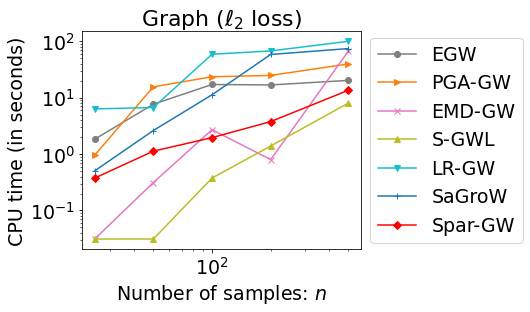

In [7]:
#############################################################################
#
# Plot the CPU time
# ---------------------------------------------

plt.figure(4, figsize=(5, 4))
pl.clf()
plt.title(r'Graph ($\ell_2$ loss)', fontsize=22)
plt.plot(n1_list, time_egw[:,2], color='tab:grey', marker='o', linestyle='-', label='EGW')
plt.plot(n1_list, time_pga[:,2], color='tab:orange', marker='>', linestyle='-', label='PGA-GW')
plt.plot(n1_list, time_emd, color='tab:pink', marker='x', linestyle='-', label='EMD-GW')
plt.plot(n1_list, time_sgwl[:,2], color='tab:olive', marker='^', linestyle='-', label='S-GWL')
plt.plot(n2_list, time_lrgw[:,2], color='tab:cyan', marker='v', linestyle='-', label='LR-GW')
plt.plot(n2_list, np.mean(time_sagrow[:,:,2], axis=0), color='tab:blue', marker='+', linestyle='-', label='SaGroW')
plt.plot(n2_list, np.mean(time_spargw[:,:,2], axis=0), color='red', marker='D', linestyle='-', label='Spar-GW')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=19)
plt.xlabel(r'Number of samples: $n$', fontsize=19)
plt.ylabel('CPU time (in seconds)', fontsize=19)
plt.xscale('log') 
plt.yscale('log')
plt.tick_params(labelsize=19)
plt.show()